### **BiN-TABL**

In [ ]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Data**
The dataset used is the LI-2010 dataset. 

As in the original paper I used the first 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [ ]:
# please change the data_path to your local path and download the free dataset

dec_data = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

h = 2        
dim = 10

y_train = dec_train[-h, :].flatten()
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print(dec_train.shape)


In [ ]:
#Computing weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [ ]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [ ]:
#Hyperparameters

batch_size = 256
epochs = 100
T = 50   #horizon    
lr = 0.001
num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

50936.0
139573.0
203786.0


### **Model Architecture**
The architecture is explained in the original paper

In [ ]:
class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,).to(device)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,).to(device)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x

In [ ]:
import math

class BiN(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1
        self.d1 = d1
        self.t2 = t2
        self.d2 = d2

        bias1 = torch.Tensor(t1, 1)
        self.B1 = nn.Parameter(bias1)
        nn.init.constant_(self.B1, 0)

        l1 = torch.Tensor(t1, 1)
        self.l1 = nn.Parameter(l1)
        nn.init.xavier_normal_(self.l1)

        bias2 = torch.Tensor(d1, 1)
        self.B2 = nn.Parameter(bias2)
        nn.init.constant_(self.B2, 0)

        l2 = torch.Tensor(d1, 1)
        self.l2 = nn.Parameter(l2)
        nn.init.xavier_normal_(self.l2)

        y1 = torch.Tensor(1, )
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.5)

        y2 = torch.Tensor(1, )
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.5)

    def forward(self, x):

        # if the two scalars are negative then we setting them to 0
        if (self.y1[0] < 0):
            y1 = torch.cuda.FloatTensor(1, )
            self.y1 = nn.Parameter(y1)
            nn.init.constant_(self.y1, 0.01)

        if (self.y2[0] < 0):
            y2 = torch.cuda.FloatTensor(1, )
            self.y2 = nn.Parameter(y2)
            nn.init.constant_(self.y2, 0.01)

        # normalization along the temporal dimensione
        T2 = torch.ones([self.t1, 1], device=device)
        x2 = torch.mean(x, dim=2)
        x2 = torch.reshape(x2, (x2.shape[0], x2.shape[1], 1))
        
        std = torch.std(x, dim=2)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))
        # it can be possible that the std of some temporal slices is 0, and this produces inf values, so we have to set them to one
        std[std < 1e-4] = 1

        diff = x - (x2 @ (T2.T))
        Z2 = diff / (std @ (T2.T))

        X2 = self.l2 @ T2.T
        X2 = X2 * Z2
        X2 = X2 + (self.B2 @ T2.T)

        # normalization along the feature dimension
        T1 = torch.ones([self.d1, 1], device=device)
        x1 = torch.mean(x, dim=1)
        x1 = torch.reshape(x1, (x1.shape[0], x1.shape[1], 1))

        std = torch.std(x, dim=1)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

        op1 = x1 @ T1.T
        op1 = torch.permute(op1, (0, 2, 1))

        op2 = std @ T1.T
        op2 = torch.permute(op2, (0, 2, 1))

        z1 = (x - op1) / (op2)
        X1 = (T1 @ self.l1.T)
        X1 = X1 * z1
        X1 = X1 + (T1 @ self.B1.T)

        # weighing the imporance of temporal and feature normalization
        x = self.y1 * X1 + self.y2 * X2

        return x

In [ ]:
class BiN_BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BiN = BiN(d2, d1, t1, t2)
    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    #first of all we pass the input to the BiN layer, then we use the B(TABL) architecture
    x = self.BiN(x)

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)


    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))


class BiN_CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()

    self.BiN = BiN(d2, d1, t1, t2)
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    #first of all we pass the input to the BiN layer, then we use the C(TABL) architecture
    x = self.BiN(x)

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)
    
    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))   
    

### **Model Training**

In [ ]:
#you can choose between the two architectures

#model = BiN_BTABL(120, 40, 10, 5, 3, 1)
model = BiN_CTABL(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)


def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    
    for it in tqdm(range(epochs)):
        
        #as written in the paper we change the lr at the 11 and 71 epochs
        if (it == 10):
              for g in optimizer.param_groups:
                g['lr'] = 0.0001

        if (it == 70):
          for g in optimizer.param_groups:
                g['lr'] = 0.00001

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:

            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            #computing the error
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        model.eval()
        
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, '/best_model_BiNCTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

In [ ]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

------- List Hyper Parameters -------
epochs   ->   200
learningRate   ->   0.001
horizon    ->     50
batch size   ->    256
Optimizer   ->    Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)


  0%|          | 1/200 [18:50<62:30:37, 1130.84s/it]

model saved
Epoch 1/200, Train Loss: 0.7595,           Validation Loss: 0.6863, Duration: 0:18:50.843132, Best Val Epoch: 0


  1%|          | 2/200 [37:38<62:04:59, 1128.79s/it]

model saved
Epoch 2/200, Train Loss: 0.6940,           Validation Loss: 0.6841, Duration: 0:18:47.341088, Best Val Epoch: 1


  2%|▏         | 3/200 [56:22<61:40:03, 1126.92s/it]

model saved
Epoch 3/200, Train Loss: 0.6919,           Validation Loss: 0.6832, Duration: 0:18:44.697621, Best Val Epoch: 2


  2%|▏         | 4/200 [1:15:06<61:16:33, 1125.48s/it]

model saved
Epoch 4/200, Train Loss: 0.6908,           Validation Loss: 0.6824, Duration: 0:18:43.256918, Best Val Epoch: 3


  2%|▎         | 5/200 [1:33:55<61:02:05, 1126.80s/it]

model saved
Epoch 5/200, Train Loss: 0.6901,           Validation Loss: 0.6817, Duration: 0:18:49.133734, Best Val Epoch: 4


  3%|▎         | 6/200 [1:52:46<60:47:43, 1128.16s/it]

Epoch 6/200, Train Loss: 0.6896,           Validation Loss: 0.6817, Duration: 0:18:50.805675, Best Val Epoch: 4


  4%|▎         | 7/200 [2:11:36<60:31:39, 1129.01s/it]

model saved
Epoch 7/200, Train Loss: 0.6894,           Validation Loss: 0.6809, Duration: 0:18:50.760190, Best Val Epoch: 6


  4%|▍         | 8/200 [2:30:27<60:14:33, 1129.55s/it]

Epoch 8/200, Train Loss: 0.6895,           Validation Loss: 0.6815, Duration: 0:18:50.701910, Best Val Epoch: 6


  4%|▍         | 9/200 [2:49:14<59:52:44, 1128.61s/it]

Epoch 9/200, Train Loss: 0.6891,           Validation Loss: 0.6822, Duration: 0:18:46.538233, Best Val Epoch: 6


  5%|▌         | 10/200 [3:08:01<59:32:50, 1128.26s/it]

Epoch 10/200, Train Loss: 0.6893,           Validation Loss: 0.6815, Duration: 0:18:47.485929, Best Val Epoch: 6


  6%|▌         | 11/200 [3:27:04<59:28:24, 1132.83s/it]

model saved
Epoch 11/200, Train Loss: 0.6880,           Validation Loss: 0.6805, Duration: 0:19:03.180409, Best Val Epoch: 10


  6%|▌         | 12/200 [3:46:02<59:14:19, 1134.36s/it]

model saved
Epoch 12/200, Train Loss: 0.6878,           Validation Loss: 0.6805, Duration: 0:18:57.856168, Best Val Epoch: 11


  6%|▋         | 13/200 [4:05:13<59:10:34, 1139.22s/it]

Epoch 13/200, Train Loss: 0.6877,           Validation Loss: 0.6805, Duration: 0:19:10.401246, Best Val Epoch: 11


  7%|▋         | 14/200 [4:24:29<59:07:51, 1144.47s/it]

Epoch 14/200, Train Loss: 0.6878,           Validation Loss: 0.6805, Duration: 0:19:16.593275, Best Val Epoch: 11


  8%|▊         | 15/200 [4:44:04<59:16:58, 1153.61s/it]

Epoch 15/200, Train Loss: 0.6877,           Validation Loss: 0.6807, Duration: 0:19:34.804892, Best Val Epoch: 11


  8%|▊         | 16/200 [5:03:59<59:35:32, 1165.94s/it]

model saved
Epoch 16/200, Train Loss: 0.6878,           Validation Loss: 0.6804, Duration: 0:19:54.559680, Best Val Epoch: 15


  8%|▊         | 17/200 [5:24:04<59:52:25, 1177.85s/it]

Epoch 17/200, Train Loss: 0.6877,           Validation Loss: 0.6805, Duration: 0:20:05.532197, Best Val Epoch: 15


  9%|▉         | 18/200 [5:44:06<59:55:13, 1185.24s/it]

Epoch 18/200, Train Loss: 0.6878,           Validation Loss: 0.6805, Duration: 0:20:02.446559, Best Val Epoch: 15


  9%|▉         | 18/200 [6:01:43<60:57:27, 1205.76s/it]


KeyboardInterrupt: ignored

### **Model Testing**

In [ ]:
model = torch.load('/best_model_BiNCTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    #outputs = torch.squeeze(outputs)
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.8810


accuracy_score: 0.8810085045101846
              precision    recall  f1-score   support

           0     0.9204    0.8194    0.8669     38464
           1     0.8480    0.9528    0.8974     65997
           2     0.9163    0.8136    0.8619     35112

    accuracy                         0.8810    139573
   macro avg     0.8949    0.8619    0.8754    139573
weighted avg     0.8851    0.8810    0.8800    139573



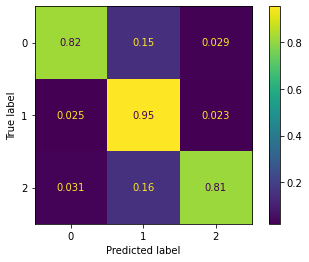

In [ ]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()